In [1]:
import numpy as np
from dipy.reconst.ivim import IvimModel
from dipy.data.fetcher import read_ivim
import dipy.core.gradients as dpg
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
img, gtab = read_ivim()
data = img.get_data()

print('data.shape (%d, %d, %d, %d)' % data.shape)

Dataset is already in place. If you want to fetch it again please first remove the folder /Users/arokem/.dipy/ivim 
data.shape (256, 256, 54, 21)


In [3]:
z = 33
x1, x2 = 90, 150
y1, y2 = 90, 180

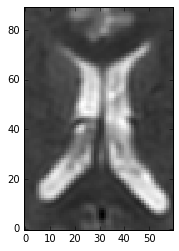

In [4]:
# Plot at b=0
b_val = 0
plt.imshow(data[x1:x2, y1:y2, z, b_val].T, origin='lower',
           cmap="gray", interpolation='nearest')
plt.show("CSF_slice.png")
plt.close()

In [26]:
# We'll look at a 2-by-2-by-2 cube
data_slice = data[90:92, 90:92, 33:35, :]

In [27]:
gtab.bvecs.shape

(21, 3)

In [28]:
data_slice.shape

(2, 2, 2, 21)

In [43]:
# Preallocate an array for the results:

predictions = np.zeros([data_slice.shape[0], 
                        data_slice.shape[1],
                        data_slice.shape[2],
                        data_slice.shape[3] - 1])

# Note that we are not predicting S0, because we always need S0 to fit the model

for left_out in range(1, data.shape[-1]-1):
    # These are the b-values/b-vectors with one of them left out:
    left_out_bvals = np.concatenate([gtab.bvals[:left_out], gtab.bvals[left_out+1:]])
    left_out_bvecs = np.concatenate([gtab.bvecs[:left_out], gtab.bvecs[left_out+1:]])
    left_out_gtab = dpg.gradient_table(left_out_bvals, left_out_bvecs)
    # Create a model for this iteration
    ivim_model = IvimModel(left_out_gtab)
    # We fit to the data leaving out the current measurement
    left_out_data = np.concatenate([data_slice[..., :left_out], 
                                    data_slice[..., left_out+1:]], -1)
    ivim_fit = ivim_model.fit(left_out_data)
    # We try to predict only the left out measurement
    predict_gtab = dpg.gradient_table(np.array([gtab.bvals[left_out]]), 
                                      np.array([gtab.bvecs[left_out]]))
    predictions[..., left_out] = ivim_fit.predict(predict_gtab, S0=data_slice[..., 0]).squeeze()

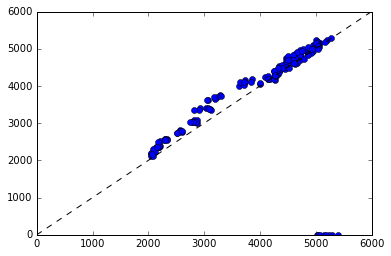

In [45]:
# Compare the predictions to the actual data:
plt.plot(data_slice[..., 1:].ravel(), predictions.ravel(), 'o')
plt.plot([0, 6000], [0, 6000], 'k--')